In [28]:
#check for libraries
!pip install pandas openpyxl

import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import plotly.graph_objects as go
#check for libraries
!pip install pandas openpyxl

import seaborn as sns
import numpy as np  # Add this import
from sqlalchemy import create_engine, text
from datetime import datetime

In [29]:
# REM local no agg Excel file
#data_path = '/Users/christinacastillo/Desktop/DS311/DS311-Group-Project-Documentation/dognition/'


#Path from git hub
data_path = 'https://raw.githubusercontent.com/castill01/DataXperts/main/data/'

# Load the no aggregation Excel file

df = pd.read_excel(f'{data_path}dognition_data_no_aggregation_with_zip_code_correction.xlsx')


In [5]:
# Keep only specified columns from dfn
df = df[['Created_at', 'User_ID']]


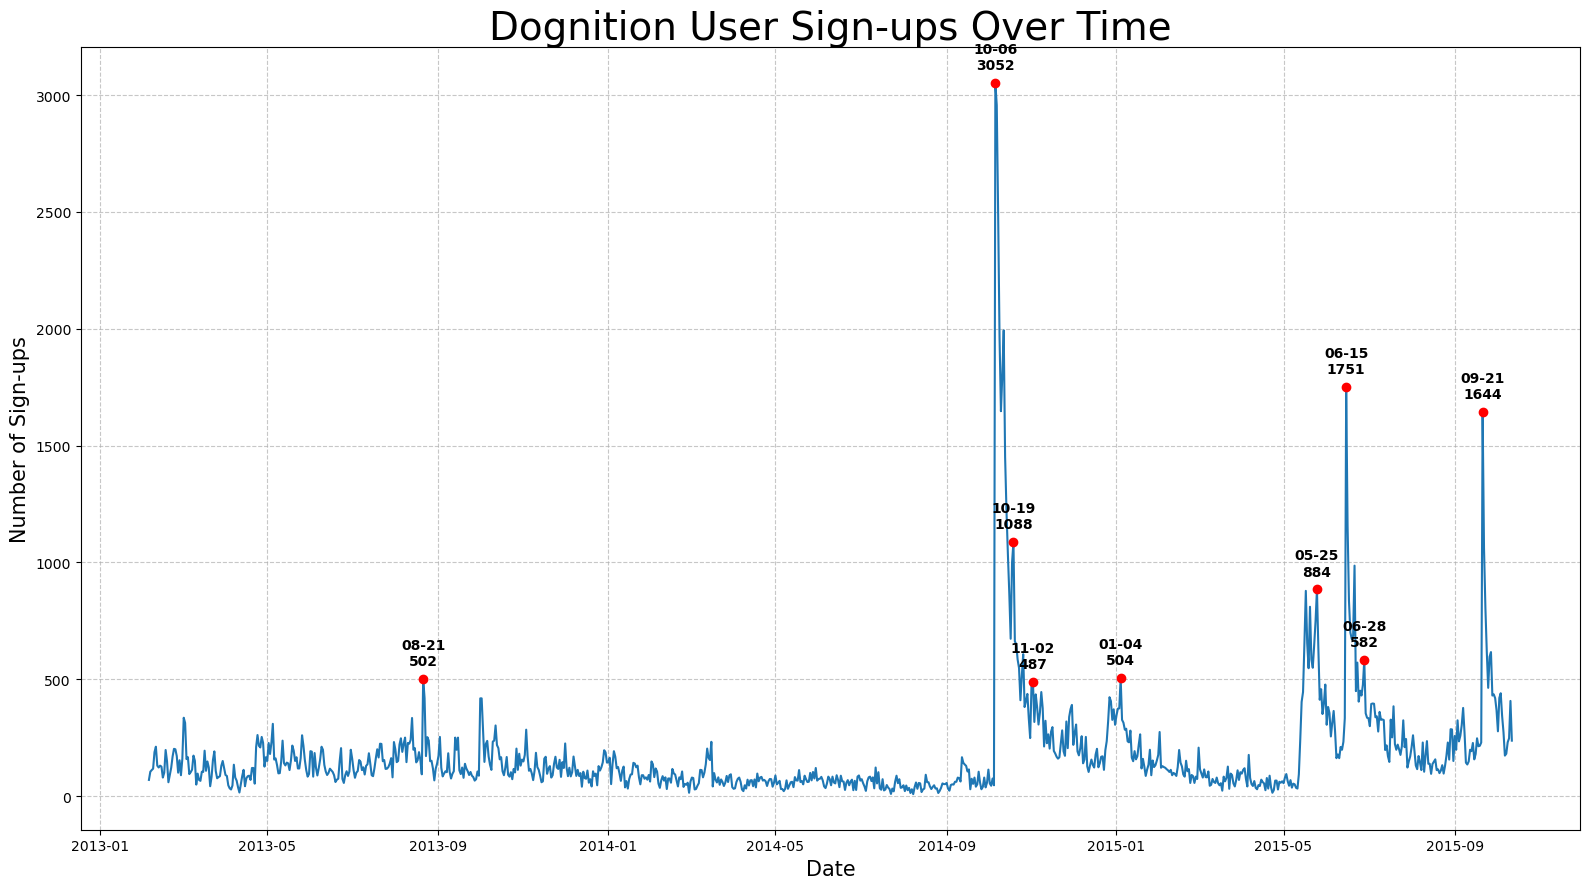

In [38]:
#look for unique user counts over time
#poinitng out the peaks

#Convert 'Created_at' to datetime if it's not already
df['Created_at'] = pd.to_datetime(df['Created_at'])

#Group the sing-ups by date and count them
signups = df['Created_at'].dt.date.value_counts().sort_index()

#Plot user sign-ups over time
plt.figure(figsize=(16,9))
signups.plot()

#Find peaks/spikes
#Starts at the 450th unique count distance every 9 days ( this all can be changed)
peaks, _ = find_peaks(signups.values, height=450, distance=9) 

#Annotate peaks
for peak in peaks:
    date = signups.index[peak]
    count = signups.values[peak]
    label = f'{date.strftime("%m-%d")}\n{count}'  # Year missing on purpose as we ran out of space
    plt.annotate(label, (date, count), textcoords="offset points", 
                 xytext=(0,10), ha='center', fontweight='bold')
    plt.plot(date, count, "ro")  # This puts the red dot on the peak

#Titles 
plt.title('Dognition User Sign-ups Over Time', fontsize=28)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of Sign-ups', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [40]:
#Q3.1Monthly Average with percent change

#Convert 'Created_at' to datetime if it's not already
df['Created_at'] = pd.to_datetime(df['Created_at'])

#Group by date and count sign-ups
signups_by_month = df.groupby(df['Created_at'].dt.to_period('M'))['User_ID'].nunique().reset_index() #unique identifier
signups_by_month.columns = ['Month', 'Number_of_Signups']


#Sort 
signups_by_monthp = signups_by_month.sort_values('Month')

#Transform to panda series a single column to a python list by .toList 

#Calculate % change
signups_by_monthp['Percent_Change'] = signups_by_monthp['Number_of_Signups'].pct_change() * 100

#Format % change
signups_by_monthp['Percent_Change'] = signups_by_monthp['Percent_Change'].apply(lambda x: f"{x:+.2f}%" if pd.notnull(x) else "N/A")

#Display the table
print(signups_by_monthp.to_string(index=False))

  Month  Number_of_Signups Percent_Change
2013-02                236            N/A
2013-03                357        +51.27%
2013-04                338         -5.32%
2013-05                516        +52.66%
2013-06                440        -14.73%
2013-07                607        +37.95%
2013-08               1015        +67.22%
2013-09                627        -38.23%
2013-10                933        +48.80%
2013-11                498        -46.62%
2013-12                461         -7.43%
2014-01                395        -14.32%
2014-02                289        -26.84%
2014-03                298         +3.11%
2014-04                264        -11.41%
2014-05                277         +4.92%
2014-06                242        -12.64%
2014-07                170        -29.75%
2014-08                154         -9.41%
2014-09                231        +50.00%
2014-10               2829      +1124.68%
2014-11               1175        -58.47%
2014-12                872        

    Year  count_Uniq_user    User_Category
0   2013                6  Canada_Loc_User
1   2013             2038       Free_Start
2   2013              154   Not_Free_Start
3   2013             2289     Nulls_Blanks
4   2014               35  Canada_Loc_User
5   2014              305       Free_Start
6   2014              325   Not_Free_Start
7   2014             4863     Nulls_Blanks
8   2015                4  Canada_Loc_User
9   2015             2204       Free_Start
10  2015              152   Not_Free_Start
11  2015             5180     Nulls_Blanks


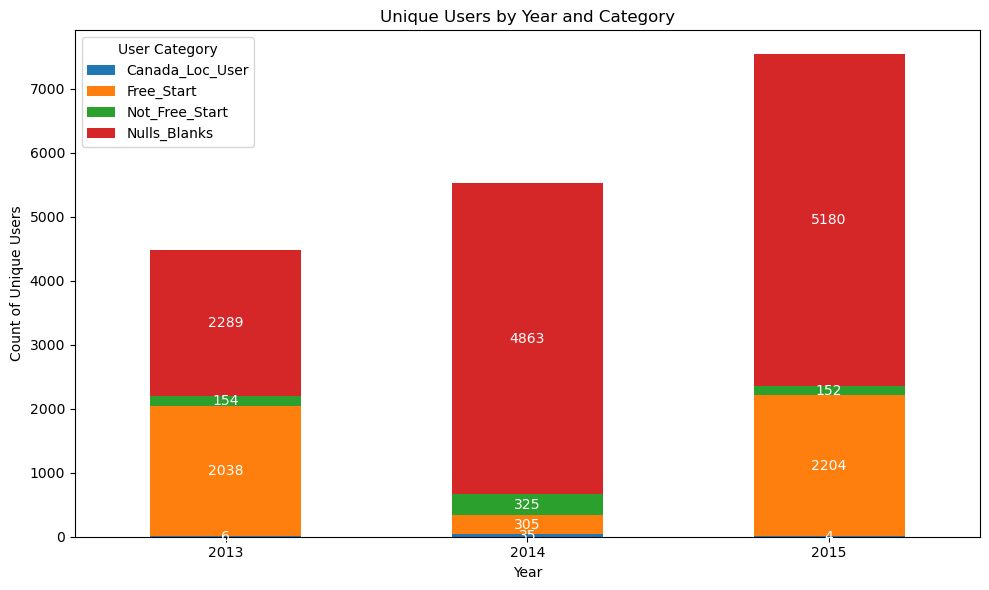

In [36]:
#question 3.2

import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

# Clean and select necessary columns
df = df[['User_ID', 'Free_Start_User', 'Created_at']]

# Convert 'Created_at' to datetime and extract the year
df['Created_at'] = pd.to_datetime(df['Created_at'], errors='coerce')
df['Year'] = df['Created_at'].dt.year

# Create a SQLite database (or connect to an existing one)
sqlite_db_path = 'dognition_data.db'
engine = create_engine(f'sqlite:///{sqlite_db_path}')

# Write the DataFrame to SQLite
df.to_sql('dognition_table', con=engine, if_exists='replace', index=False)

# SQL query to count unique users by year and handle Canada locations
query = """
SELECT 
    Year,
    COUNT(DISTINCT User_ID) AS count_Uniq_user,
    CASE 
        WHEN Free_Start_User = '0' THEN 'Not_Free_Start'
        WHEN Free_Start_User = '1' THEN 'Free_Start'
        WHEN Free_Start_User IS NULL OR Free_Start_User = '' THEN 'Nulls_Blanks'
        ELSE 'Canada_Loc_User' 
    END AS User_Category
FROM 
    dognition_table
GROUP BY 
    Year, User_Category;
"""

# Execute the query and fetch results
with engine.connect() as connection:
    result = connection.execute(text(query)).fetchall()

# Convert results to a DataFrame
results_df = pd.DataFrame(result, columns=['Year', 'count_Uniq_user', 'User_Category'])

# Display the DataFrame as a table
print(results_df)


# Pivot the DataFrame to prepare for plotting
#Without this variable defined it will create a nameError - means to create teh pivot table from results_df before attempting to plot
pivot_df = results_df.pivot(index='Year', columns='User_Category', values='count_Uniq_user').fillna(0)

# Plot the output
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add data labels
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10, color='white')

plt.title('Unique Users by Year and Category')
plt.xlabel('Year')
plt.ylabel('Count of Unique Users')
plt.legend(title='User Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

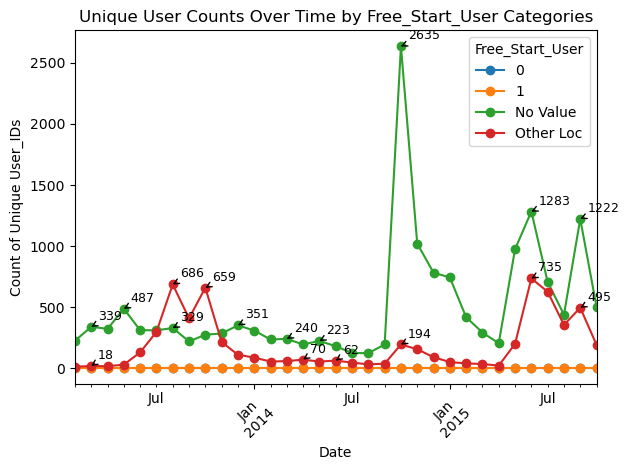

In [42]:
#Continue 3.2

# Replace NaN values in Free_Start_User with 'No Value'
df['Free_Start_User'] = df['Free_Start_User'].fillna('No Value')

# Merge categories: set 'Other Loc' for values not in ['0', '1', 'No Value']
df['Free_Start_User'] = df['Free_Start_User'].apply(
    lambda x: 'Other Loc' if x not in ['0', '1', 'No Value'] else x
)

# Convert Created_at to datetime
df['Created_at'] = pd.to_datetime(df['Created_at'])

# Filter only relevant Free_Start_User categories
df_filtered = df[df['Free_Start_User'].isin(['0', '1', 'No Value', 'Other Loc'])]

# Group by date and Free_Start_User, and count unique User_IDs
time_series_counts = (
    df_filtered.groupby([df_filtered['Created_at'].dt.to_period('M'), 'Free_Start_User'])['User_ID']
    .nunique()
    .reset_index(name='Unique_User_Count')
)

# Pivot the table for better visualization
pivot_table = time_series_counts.pivot(index='Created_at', columns='Free_Start_User', values='Unique_User_Count').fillna(0)

# Ensure all categories are represented
for category in ['0', '1', 'No Value', 'Other Loc']:
    if category not in pivot_table.columns:
        pivot_table[category] = 0

# Reorder columns to maintain desired order in the legend
pivot_table = pivot_table[['0', '1', 'No Value', 'Other Loc']]

# Plot the time series
plt.figure(figsize=(12, 6))
lines = pivot_table.plot(kind='line', marker='o')

# Adding data labels at peaks
for col in pivot_table.columns:
    y_data = pivot_table[col].values
    x_data = pivot_table.index

    # Identify peaks for labeling
    peak_indices = (y_data[1:-1] > y_data[:-2]) & (y_data[1:-1] > y_data[2:])
    peak_indices = np.concatenate(([False], peak_indices, [False]))  # Adjust for indexing

    # Annotate peaks
    for i in range(len(peak_indices)):
        if peak_indices[i]:
            plt.annotate(f'{int(y_data[i])}', 
                         xy=(x_data[i].to_timestamp(), y_data[i]), 
                         xytext=(5, 5), 
                         textcoords='offset points',
                         fontsize=9, 
                         arrowprops=dict(arrowstyle='->', color='black'))

plt.title('Unique User Counts Over Time by Free_Start_User Categories')
plt.xlabel('Date')
plt.ylabel('Count of Unique User_IDs')
plt.xticks(rotation=45)
plt.legend(title='Free_Start_User')
plt.tight_layout()
plt.show()


In [44]:
#q3.3


#The dataset
dfn = pd.read_excel(f'{data_path}dognition_data_no_aggregation_with_zip_code_correction.xlsx')

# Check for required columns
required_columns = ['Created_at', 'User_ID', 'Test_name']
if not all(col in dfn.columns for col in required_columns):
    raise ValueError(f"The DataFrame must contain these columns: {required_columns}")

# Check if Updated_at is available, use Created_at if not
if 'Updated_at' in dfn.columns:
    dfn['Last_Activity'] = dfn[['Created_at', 'Updated_at']].max(axis=1)
else:
    print("'Updated_at' column not found. Using 'Created_at' for last activity date.")
    dfn['Last_Activity'] = dfn['Created_at']

# Ensure date columns are in datetime format
dfn['Created_at'] = pd.to_datetime(dfn['Created_at'])
dfn['Last_Activity'] = pd.to_datetime(dfn['Last_Activity'])

# User sampling options
use_sample = input("Do you want to analyze a sample of users? (yes/no): ").lower().strip() == 'yes'



if use_sample:
    num_users_to_sample = int(input("Enter the number of users to sample: "))
    sample_users = dfn['User_ID'].sample(num_users_to_sample).tolist()
    dfn_filtered = dfn[dfn['User_ID'].isin(sample_users)]
else:
    sample_users = dfn['User_ID'].unique().tolist()
    num_users_to_sample = len(sample_users)
    dfn_filtered = dfn

print(f"Analyzing data for {num_users_to_sample} users.")

# Calculate the overall date range for context
overall_start = dfn_filtered['Created_at'].min()
overall_end = dfn_filtered['Last_Activity'].max()
overall_range_days = (overall_end - overall_start).days

# Group by Test_name and calculate metrics
product_usage = dfn_filtered.groupby('Test_name').agg(
    First_Use=('Created_at', 'min'),
    Last_Use=('Last_Activity', 'max'),
    Total_Uses=('User_ID', 'count'),
    Unique_Users=('User_ID', 'nunique')
).reset_index()

# Ensure Last_Use is in datetime format
product_usage['Last_Use'] = pd.to_datetime(product_usage['Last_Use'])

# Calculate usage duration and other metrics
product_usage['Usage_Duration_Days'] = (product_usage['Last_Use'] - product_usage['First_Use']).dt.days
product_usage['Avg_Uses_Per_User'] = product_usage['Total_Uses'] / product_usage['Unique_Users']
product_usage['Usage_Span_Percentage'] = (product_usage['Usage_Duration_Days'] / overall_range_days * 100).round(2)

# Calculate days since last use (from the most recent date in the dataset)
product_usage['Days_Since_Last_Use'] = (overall_end - product_usage['Last_Use']).dt.days

# Sort by Usage_Duration_Days in descending order
product_usage = product_usage.sort_values('Usage_Duration_Days', ascending=False)

# Format dates after all calculations are done
product_usage['First_Use'] = product_usage['First_Use'].dt.strftime('%Y-%m-%d')
product_usage['Last_Use'] = product_usage['Last_Use'].dt.strftime('%Y-%m-%d')

# Add information about the date range used for analysis
print(f"\nAnalysis Date Range:")
print(f"Start Date: {overall_start.strftime('%Y-%m-%d')}")
print(f"End Date: {overall_end.strftime('%Y-%m-%d')}")
print(f"Total Days in Range: {overall_range_days}")

# Print the summary
print(f"\nProduct Usage Duration Analysis")
print(f"Overall Date Range: {overall_start.strftime('%Y-%m-%d')} to {overall_end.strftime('%Y-%m-%d')}, {overall_range_days} days")
print(product_usage.to_string(index=False))

# Export to Excel
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
excel_file_name = f"dognition_product_usage_duration_{timestamp}.xlsx"

with pd.ExcelWriter(excel_file_name, engine='openpyxl') as writer:
    product_usage.to_excel(writer, index=False, sheet_name='Product Usage Duration')
    
    # Add a sheet with sample user IDs if sampling was used
    if use_sample:
        pd.DataFrame({'Sample User IDs': sample_users}).to_excel(writer, index=False, sheet_name='Sample Users')
    
    # Add a sheet with analysis parameters
    pd.DataFrame({
        'Parameter': ['Analysis Date', 'Overall Start Date', 'Overall End Date', 'Total Days', 'Number of Users Analyzed'],
        'Value': [datetime.now().strftime('%Y-%m-%d'), overall_start.strftime('%Y-%m-%d'), 
                  overall_end.strftime('%Y-%m-%d'), overall_range_days, num_users_to_sample]
    }).to_excel(writer, index=False, sheet_name='Analysis Parameters')
    
    # Adjust column widths
    for sheet in writer.sheets:
        worksheet = writer.sheets[sheet]
        for idx, col in enumerate(worksheet.columns):
            max_length = max(len(str(cell.value)) for cell in col)
            worksheet.column_dimensions[col[0].column_letter].width = max_length + 2

print(f"\nAnalysis exported to Excel file: {excel_file_name}")

Do you want to analyze a sample of users? (yes/no):  no


Analyzing data for 16261 users.

Analysis Date Range:
Start Date: 2013-02-05
End Date: 2015-10-12
Total Days in Range: 979

Product Usage Duration Analysis
Overall Date Range: 2013-02-05 to 2015-10-12, 979 days
                    Test_name  First_Use   Last_Use  Total_Uses  Unique_Users  Usage_Duration_Days  Avg_Uses_Per_User  Usage_Span_Percentage  Days_Since_Last_Use
                 Yawn Warm-up 2013-02-05 2015-10-12       17498         16067                  979           1.089065                 100.00                    0
          Eye Contact Warm-up 2013-02-05 2015-10-12       14953         13757                  979           1.086938                 100.00                    0
              One Cup Warm-up 2013-02-05 2015-10-12        6208          5641                  979           1.100514                 100.00                    0
              Two Cup Warm-up 2013-02-05 2015-10-12        6090          5546                  979           1.098089                 100.00 

In [54]:

#The dataset
dfn = pd.read_excel(f'{data_path}dognition_data_no_aggregation_with_zip_code_correction.xlsx')

# Keep only specified columns from dfn
dfn = dfn[['Created_at', 'User_ID', 'Test_name']].copy()  #added .copy() 10/20

# Added 10/20
# Ensure Created_at is in datetime format and handle errors
dfn['Created_at'] = pd.to_datetime(dfn['Created_at'], errors='coerce')  # Coerce errors to NaT

#QA
#Added on 10/20
# Count the number of NaT/NaN (null) values in the 'Created_at' column
num_nat_rows = dfn['Created_at'].isna().sum()
#
# Print the result
print(f"Number of rows with NaT/Nan or null in 'Created_at': {num_nat_rows}")
#

#Added 10/20
# Drop rows with NaT in Created_at if necessary
dfn = dfn.dropna(subset=['Created_at'])

# Extract only the date for counting unique usage days
dfn.loc[:, 'Usage_Day'] = dfn['Created_at'].dt.date  # Using the  .loc[] to avoid warning



#Rem on 10/20
# Group by Test_name and Created_at to calculate usage metrics
#dfn['Created_at'] = pd.to_datetime(dfn['Created_at'])  # Ensure Created_at is in datetime format
#dfn['Usage_Day'] = dfn['Created_at'].dt.date  # Extract only the date for counting unique usage days

# Group and calculate usage metrics
summary = dfn.groupby('Test_name').agg(
    Day_Usage_Count=('Usage_Day', 'nunique'),  # Count of unique days the test was used
    Unique_Users=('User_ID', 'nunique')        # Count of unique User_IDs
).reset_index()

# Calculate Months Used
summary['Months_Used'] = summary['Day_Usage_Count'] / 30  # Assuming average month length is 30 days

# Generate statistical summary for Days Used, Months Used, and Unique Users
stats_summary = summary[['Day_Usage_Count', 'Months_Used', 'Unique_Users']].describe()

# Display the summary
print("Statistical Summary of Days Used, Months Used, and Unique Users:")
print(stats_summary)



Number of rows with NaT in 'Created_at': 0
Statistical Summary of Days Used, Months Used, and Unique Users:
       Day_Usage_Count  Months_Used  Unique_Users
count        41.000000    41.000000     41.000000
mean        565.926829    18.864228   3918.121951
std         377.647282    12.588243   4674.073824
min          68.000000     2.266667     69.000000
25%         152.000000     5.066667    163.000000
50%         411.000000    13.700000    556.000000
75%         940.000000    31.333333   6422.000000
max         957.000000    31.900000  16067.000000


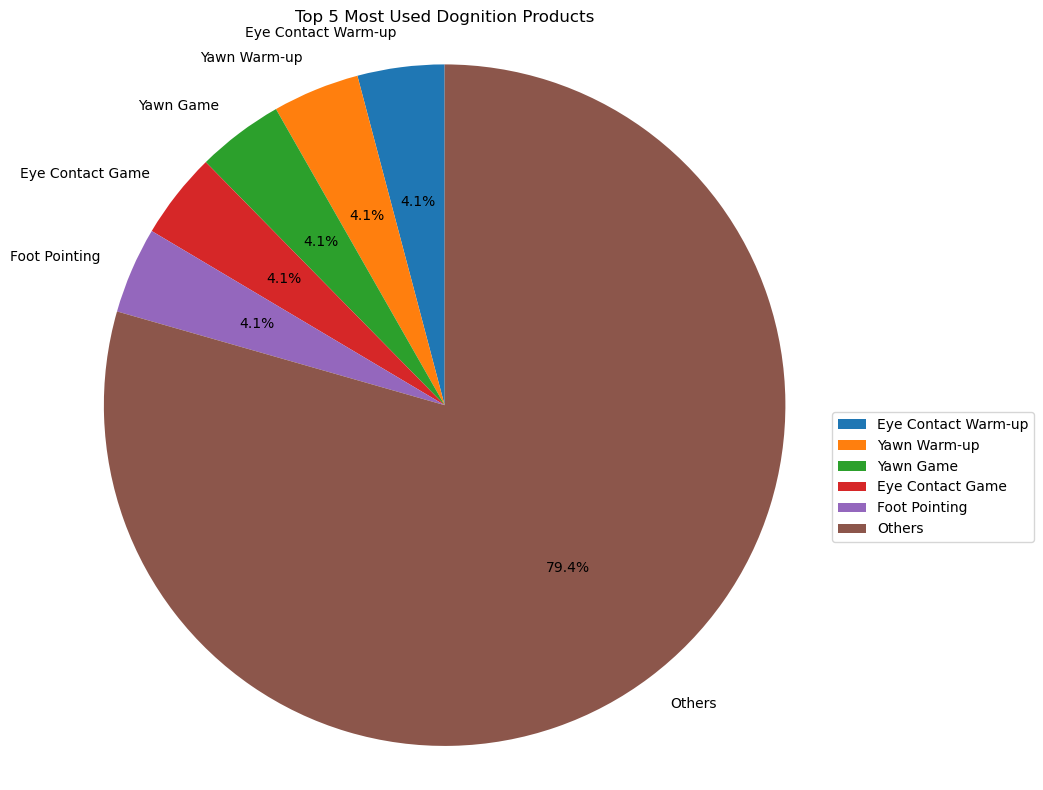


Product Usage Percentages:
Eye Contact Warm-up     4.12
Yawn Warm-up            4.12
Yawn Game               4.12
Eye Contact Game        4.10
Foot Pointing           4.10
Others                 79.42
dtype: float64

Total number of unique products: 41


In [56]:
# Assuming 'summary' DataFrame is already created and contains 'Test_name' and 'Day_Usage_Count'


# Group by Test_name and sum the Day_Usage_Count
product_usage = summary.groupby('Test_name')['Day_Usage_Count'].sum().sort_values(ascending=False)

# Calculate the percentage of total usage for each product
total_usage = product_usage.sum()
product_usage_percent = (product_usage / total_usage * 100).round(2)

# Select top 5 products and combine the rest into 'Others'
top_5_products = product_usage_percent.head(5)
others = pd.Series({'Others': product_usage_percent.iloc[5:].sum()})
pie_data = pd.concat([top_5_products, others])

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=90)
plt.title('Top 5 Most Used Dognition Products')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add a legend
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Print the data used for the pie chart
print("\nProduct Usage Percentages:")
print(pie_data)

# Print total number of products
print(f"\nTotal number of unique products: {len(product_usage)}")

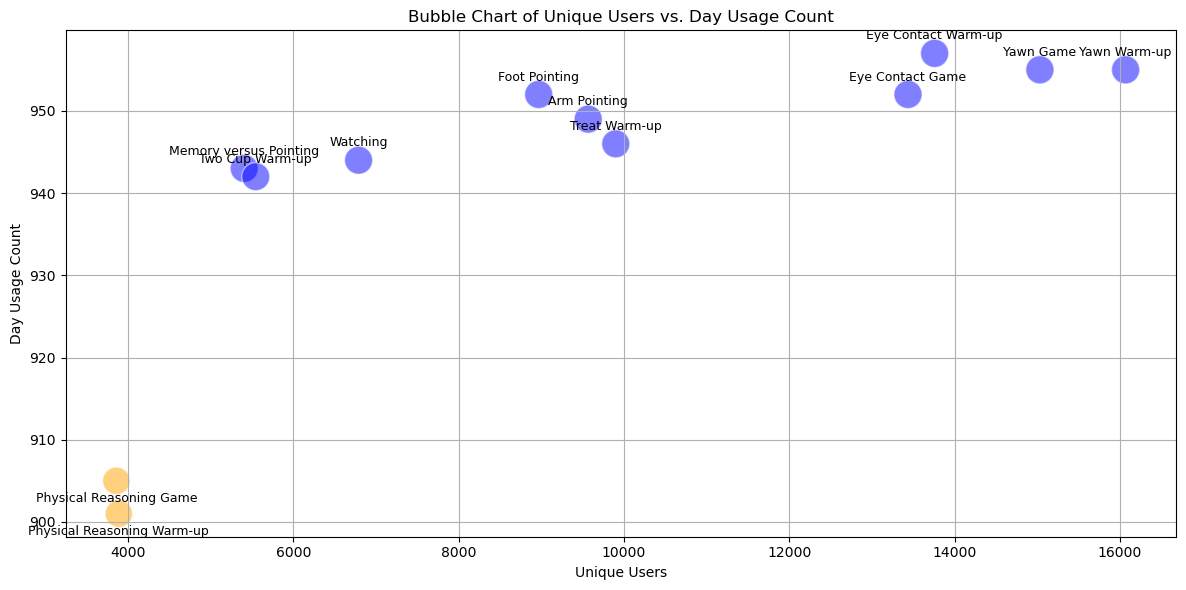

In [58]:
# Sample DataFrame (replace with your actual data loading)
data = {
    'Test_name': [
        'Yawn Warm-up', 'Yawn Game', 'Eye Contact Warm-up', 'Eye Contact Game',
        'Foot Pointing', 'Arm Pointing', 'Treat Warm-up', 'Watching', 
        'Two Cup Warm-up', 'Memory versus Pointing', 'One Cup Warm-up',
        'Turn Your Back', 'Cover Your Eyes', 'Memory versus Smell',
        'Watching - Part 2', 'Delayed Cup Game', 'Inferential Reasoning Warm-up',
        'Physical Reasoning Game', 'Inferential Reasoning Game', 'Physical Reasoning Warm-up'
    ],
    'Day_Usage_Count': [955, 955, 957, 952, 952, 949, 946, 944, 942, 943, 
                        940, 939, 938, 936, 931, 922, 906, 905, 906, 901],
    'Unique_Users': [16067, 15030, 13757, 13435, 8968, 9567, 9900, 6790, 5546, 5406,
                     5641, 6686, 6534, 5017, 6422, 4807, 4099, 3860, 3999, 3890],
    'Percent_of_Total': [4.12, 4.12, 4.12, 4.10, 4.10, 4.09, 4.08, 4.07, 4.06, 4.06,
                         4.05, 4.05, 4.04, 4.03, 4.01, 3.97, 3.90, 3.90, 3.90, 3.88]
}

summary = pd.DataFrame(data)

# Get the top 10 and lowest 2 based on Day Usage Count
top_10 = summary.sort_values(by='Day_Usage_Count', ascending=False).head(10)
lowest_2 = summary.sort_values(by='Day_Usage_Count').head(2)

# Concatenate top and lowest dataframes
combined_summary = pd.concat([top_10, lowest_2])

# Create a bubble chart
plt.figure(figsize=(12, 6))
bubble = plt.scatter(
    combined_summary['Unique_Users'], 
    combined_summary['Day_Usage_Count'], 
    s=combined_summary['Percent_of_Total'] * 100,  # Scale size for better visibility
    alpha=0.5, 
    edgecolors='w', 
    color=['blue'] * len(top_10) + ['orange'] * len(lowest_2)
)

# Adding title and labels
plt.title('Bubble Chart of Unique Users vs. Day Usage Count')
plt.xlabel('Unique Users')
plt.ylabel('Day Usage Count')

# Adding annotations for top 10 and bottom 2 tests
for index, row in top_10.iterrows():
    plt.annotate(row['Test_name'], 
                 (row['Unique_Users'], row['Day_Usage_Count']), 
                 textcoords="offset points", 
                 xytext=(0, 10), 
                 ha='center', fontsize=9)

for index, row in lowest_2.iterrows():
    plt.annotate(row['Test_name'], 
                 (row['Unique_Users'], row['Day_Usage_Count']), 
                 textcoords="offset points", 
                 xytext=(0, -15), 
                 ha='center', fontsize=9)
    
# Show the plot
plt.grid()
plt.tight_layout()
plt.show()